In [23]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import matplotlib.pyplot as plt
import numpy as np
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import \
    get_config
#from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
config = get_config()

In [25]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape == y_pred.shape and len(y_pred.shape) == 1)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [26]:
if "fQuadSin" in config.data_path:
    minx = -1.5
    ts_type = "fQuadSin"
    include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
elif "fBiPotSmall" in config.data_path:
    minx = -1.5
    ts_type = "fBiPotSmall"
    include = None
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
    include = (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
        ".", "")
maxx = -minx

In [27]:
import os
import re
keepfiles = []
root_dir = project_config.ROOT_DIR + f"experiments/results/"
for file in os.listdir(root_dir):
    if "Nadaraya" in file and ts_type in file and include in file and "DriftEvalExp" in file and f"{config.ts_length}NumDPS" in file:
        keepfiles.append(root_dir+file)
print(len(keepfiles), ts_type)
assert len(keepfiles)>0, "No files found"
def extract_bw_number(s):
    match = s.split("/")[-1].split("_")[3][:-2]
    return float("0." + match)


keepfiles = sorted(keepfiles, key=extract_bw_number)
bws = [extract_bw_number(f) for f in keepfiles]
Xshape = np.load(keepfiles[0]).shape[0]
print(keepfiles)

20 fQuadSin
['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00001bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00002bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00003bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00004bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00007bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/exper

In [28]:
vispaths = np.linspace(minx, maxx, Xshape)
num_paths = 10952
if "QuadSin" in config.data_path:
    print(config.quad_coeff, config.sin_coeff, config.sin_space_scale, config.deltaT)
    is_true_drift = -2.*config.quad_coeff * vispaths.flatten() + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*vispaths.flatten())
elif "fSin" in config.data_path:
    is_true_drift = config.mean_rev*np.sin(vispaths.flatten())
elif "BiPot" in config.data_path:
    is_true_drift = -(4.*config.quartic_coeff * np.power(vispaths, 3) + 2.*config.quad_coeff * vispaths + config.const).flatten()
print(ts_type)

0.5 0.04 25.0 0.00390625
fQuadSin


/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00001bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)


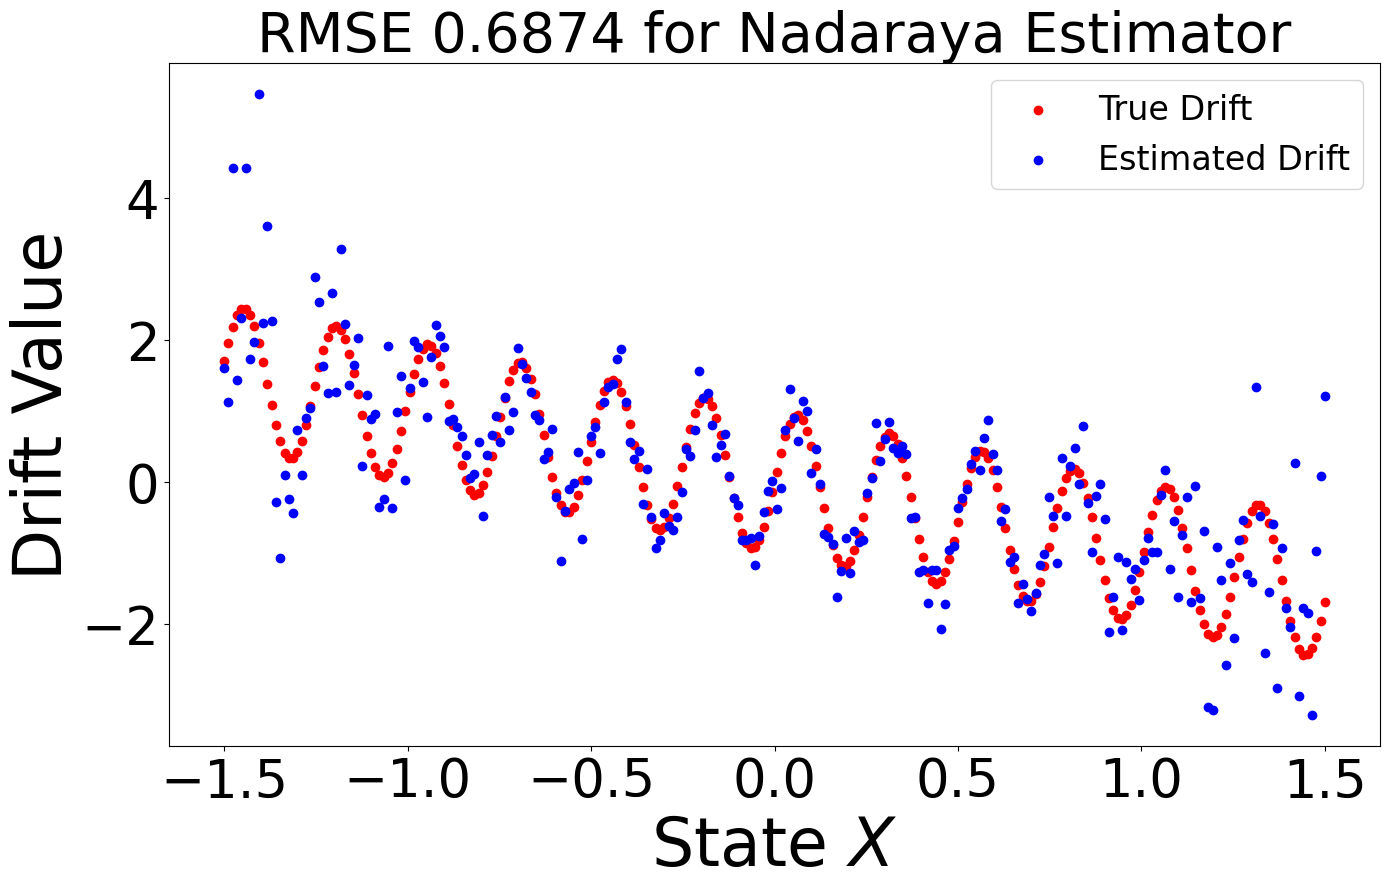

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00002bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)


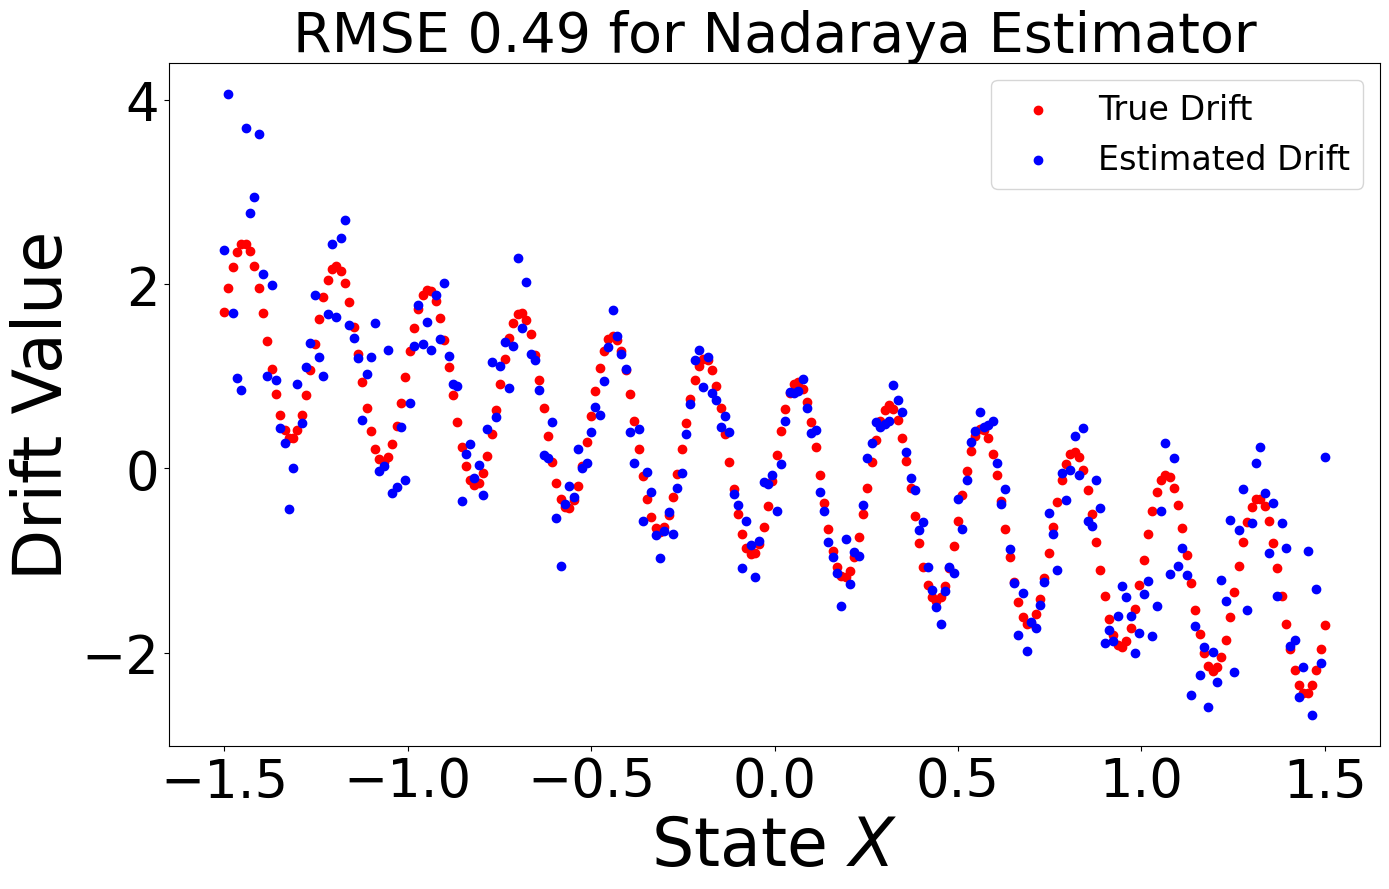

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00003bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)


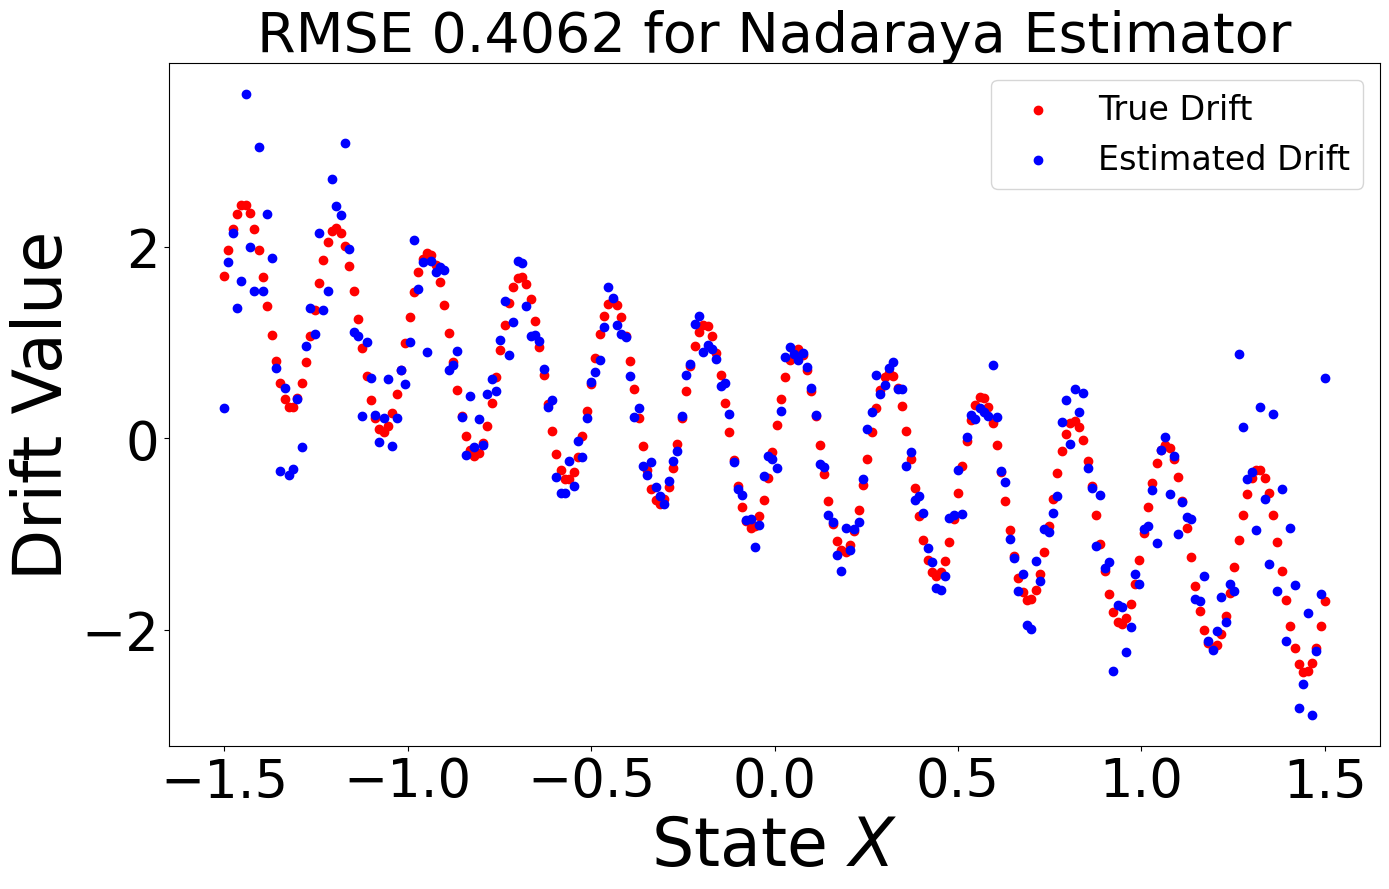

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00004bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)


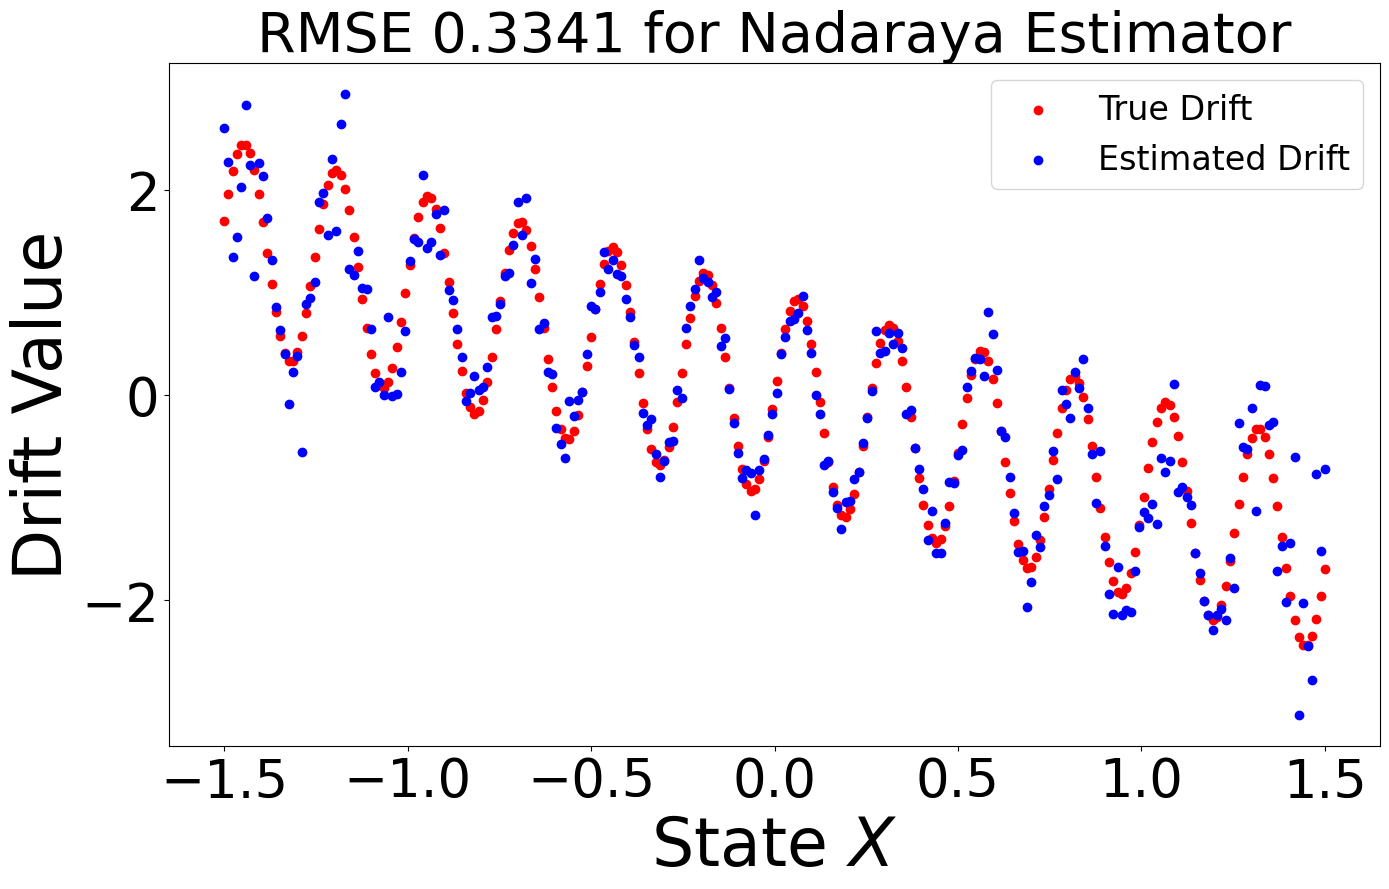

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00007bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)


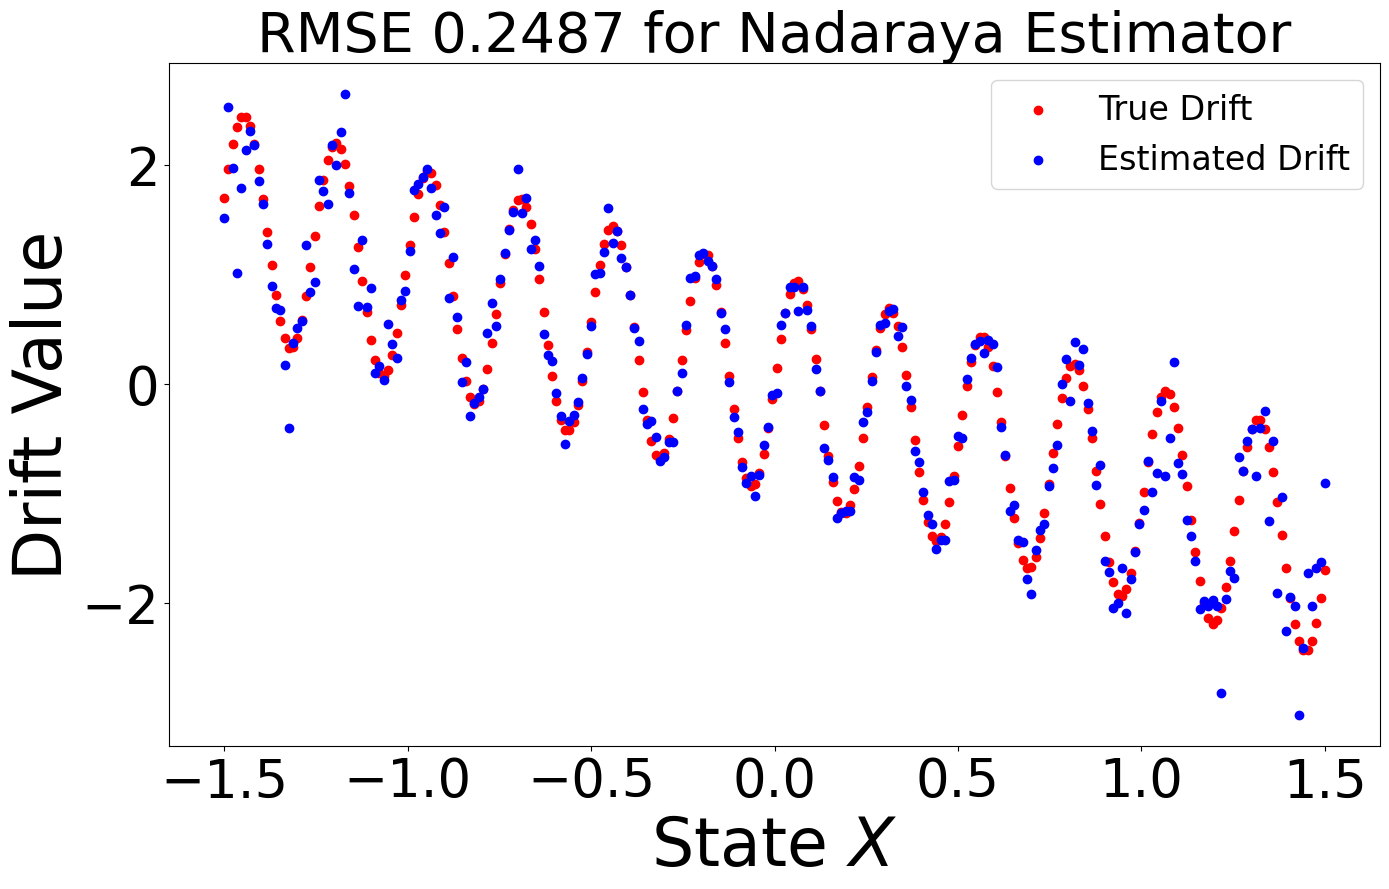

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00011bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)


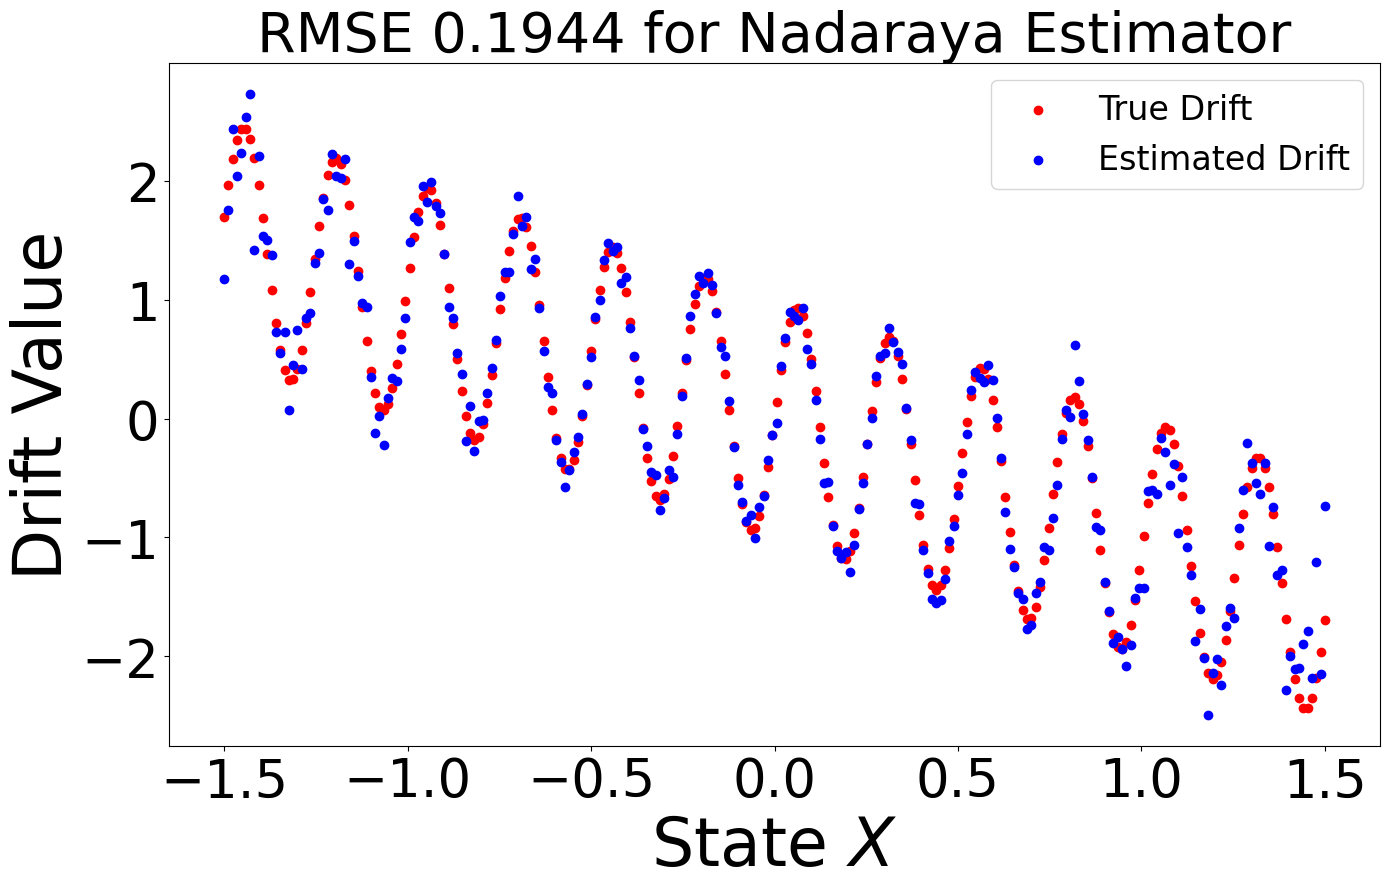

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00018bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)


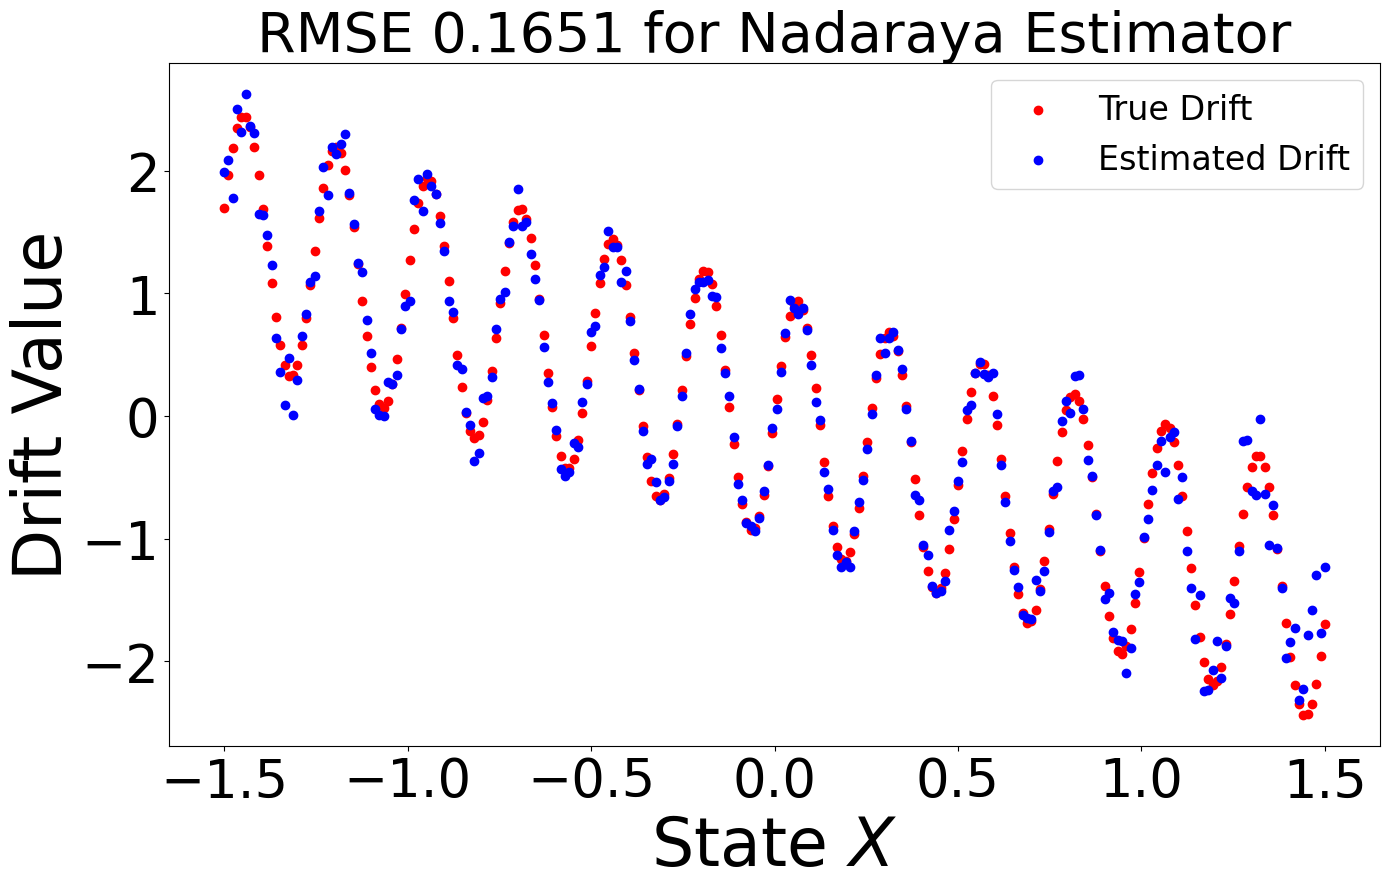

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00029bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)


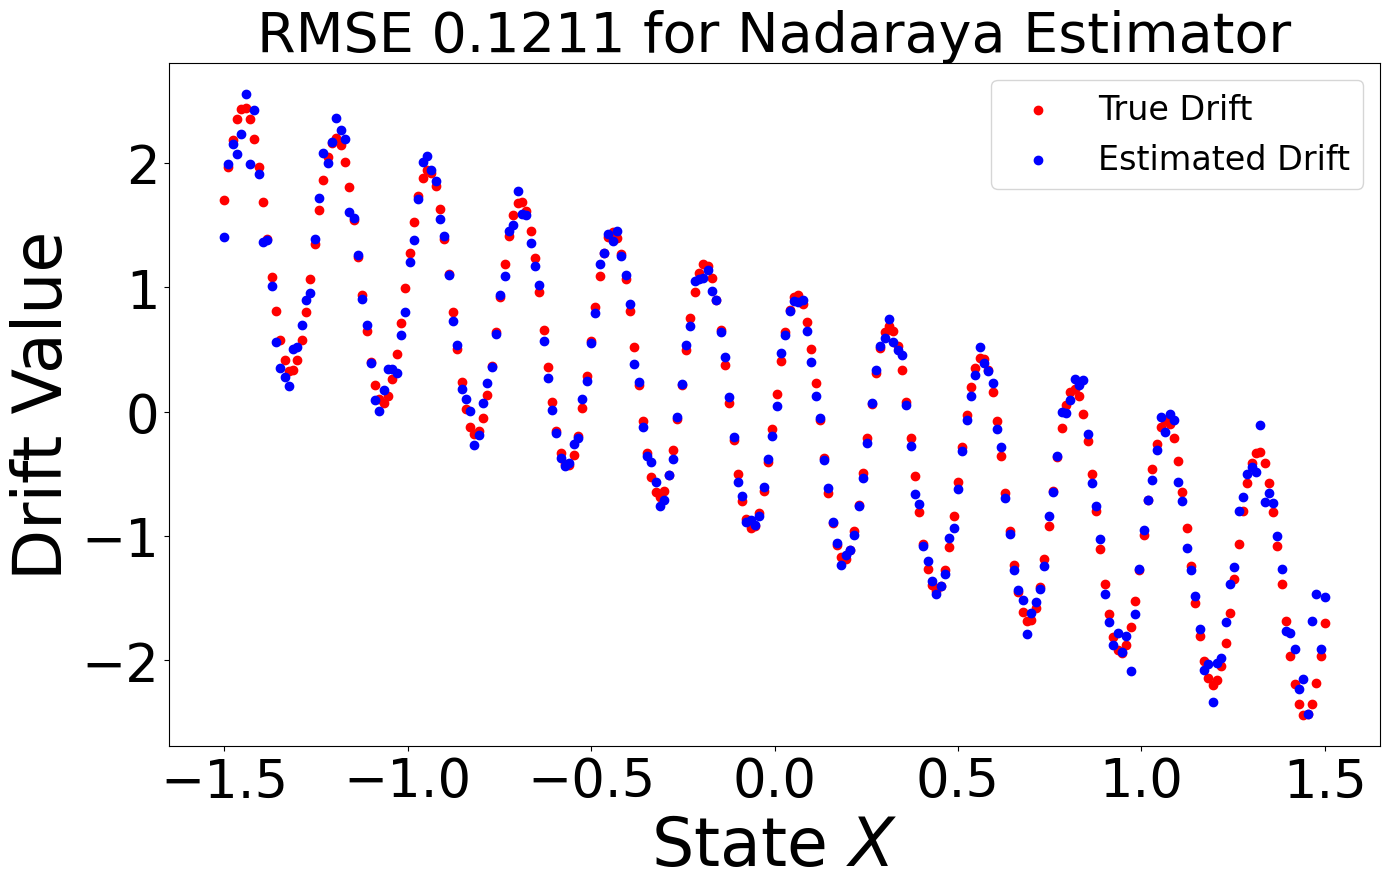

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00046bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)


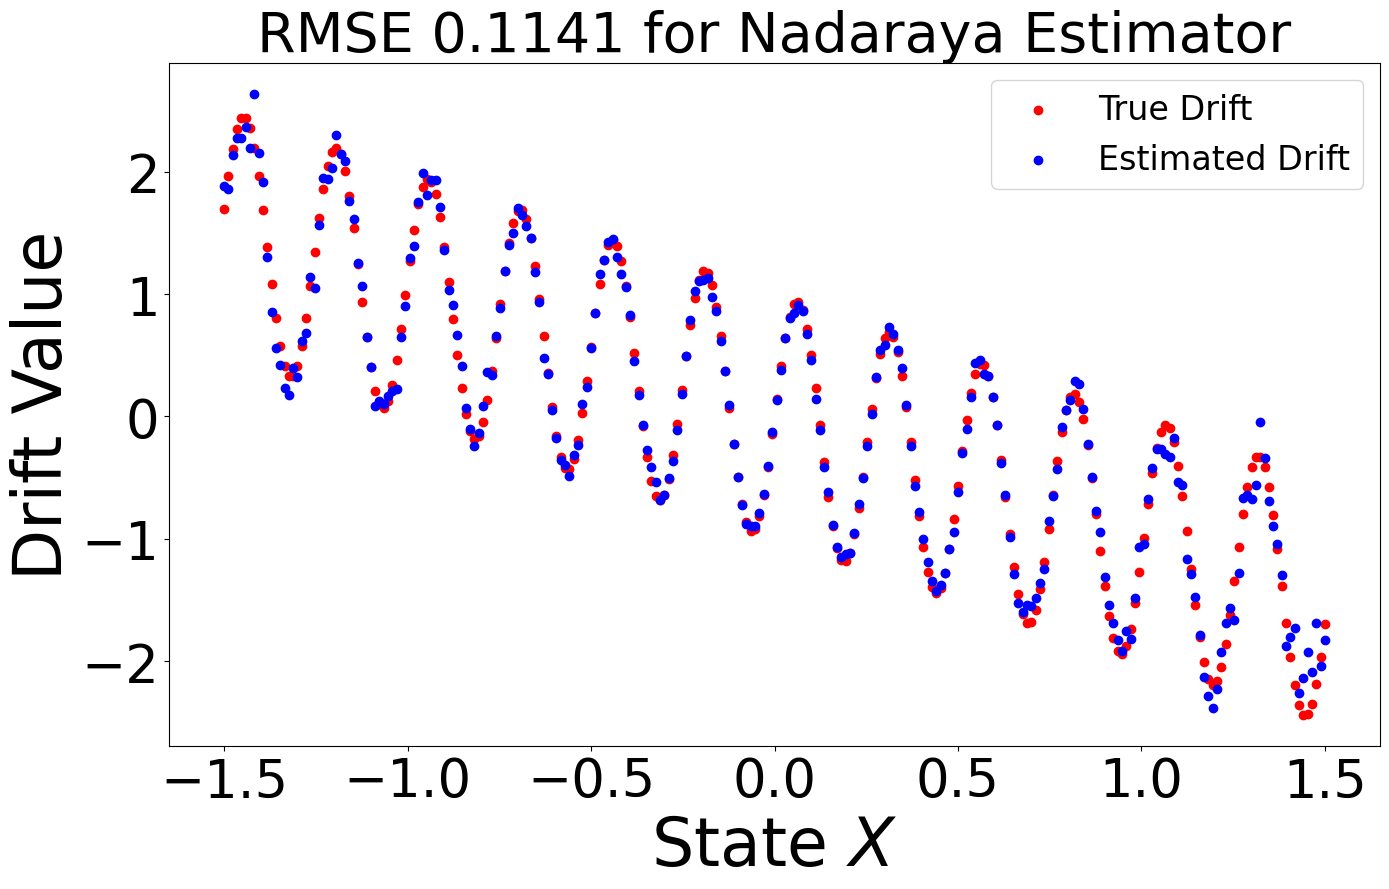

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00074bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)


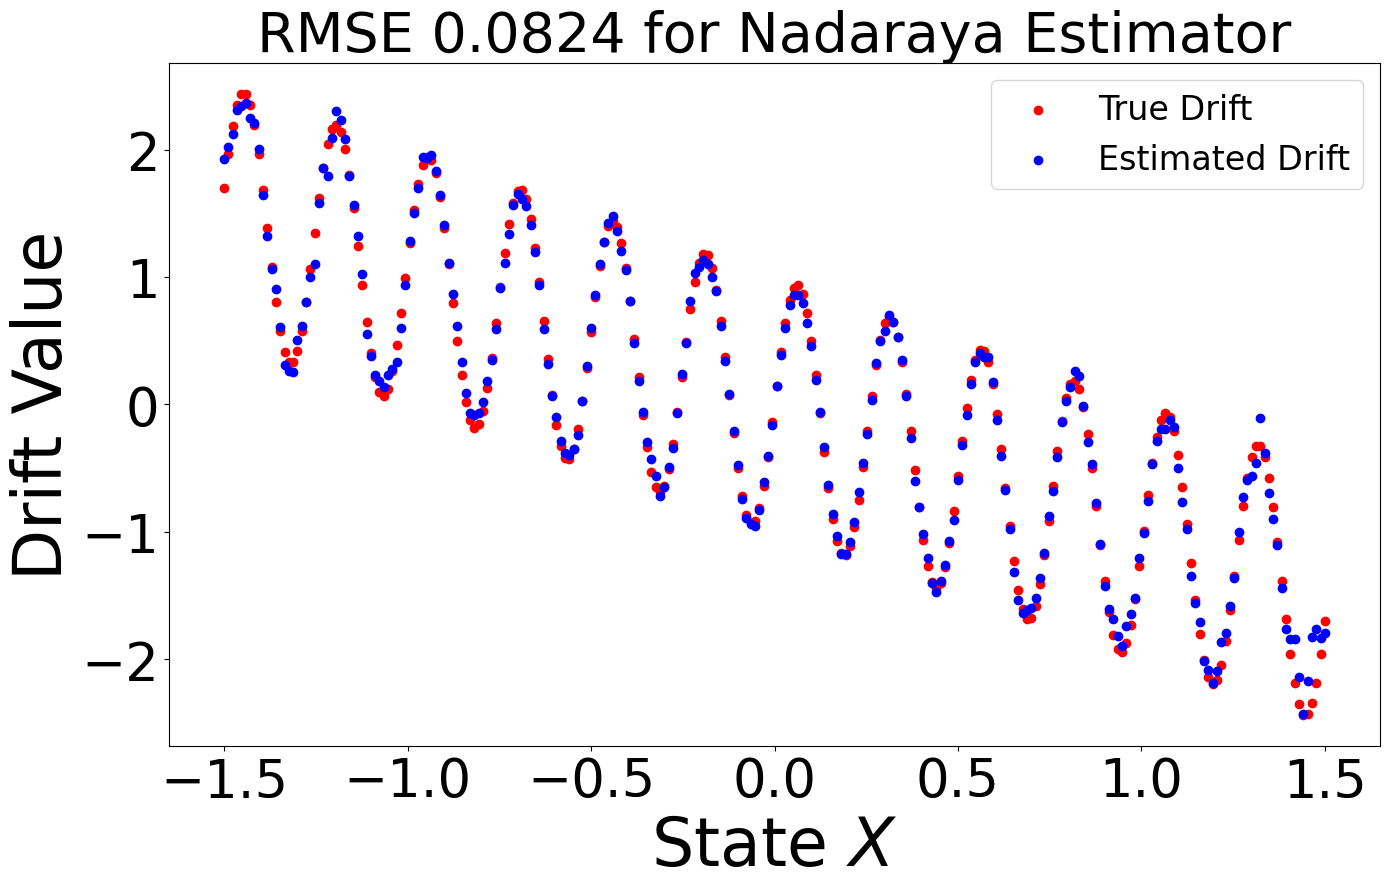

/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_0012bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)
/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00194bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)
/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00312bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)
/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00504bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)
/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fQuadSinHF_DriftEvalExp_00814bw_10952NPaths_00t0_3906e-03dT_05a_004b_250c_256NumDPS_isdriftHats.npy
(256,) (256,)
/Users/marcos/Gi

In [29]:
curr_rmse = np.inf
for f_idx in range(len(keepfiles)):
    bw = bws[f_idx]
    f = keepfiles[f_idx]
    try:
        print(f)
        is_drift = np.load(f).mean(axis=-1).flatten()
        print(is_drift.shape, is_true_drift.shape)
        rmse = (rmse_ignore_nans(is_true_drift, is_drift))
        if rmse < curr_rmse:
            curr_rmse = rmse
            fig, ax = plt.subplots(figsize=(14,9))
            plt.scatter(vispaths, is_true_drift,label="True Drift", color="red")
            plt.scatter(vispaths, is_drift, label="Estimated Drift", color="blue")
            plt.legend(fontsize=18)
            plt.title(f"RMSE {round(rmse, 4)} for Nadaraya Estimator", fontsize=40)
            ax.tick_params(labelsize=38)
            plt.ylabel("Drift Value", fontsize=48)
            plt.xlabel(r"State $X$", fontsize=48)
            plt.legend(fontsize=24)
            plt.tight_layout()
            plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type}2_DriftEvalExp_IIDNadaraya_{round(bw, 6)}bw_{config.deltaT:.3e}dT".replace(".","")+".png",  bbox_inches='tight')
            plt.show()
            plt.close()
    except ValueError as e:
        plt.close()
        continue
